In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint
import os

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

In [2]:
df = pd.read_csv('/content/winequality-red.csv')
df

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5
...,...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


# EDA (Exploratory Data Analysis)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [4]:
df.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Dari sini, kita bisa menemukan beberapa fakta:
- Tidak ada data yang **NULL** (total data = 1599)
- Terdapat 12 fitur / kolom dan sesuai keterangan pemilik dataset bahwa fitur `quality` akan menjadi targetnya
- Semua data berbentuk numerik (*float* dan *int*)
- Fitur `quality` ternyata hanya bernilai dari 3 hingga 8 (tidak sesuai keterangan pemilik dataset bahwa bernilai 0 hingga 10)
- Fitur `pH` bernilai 2.74 hingga 4.01 sehingga menunjukkan bahwa dataset ini sesuai kondisi riil (*wine* bersifat asam)

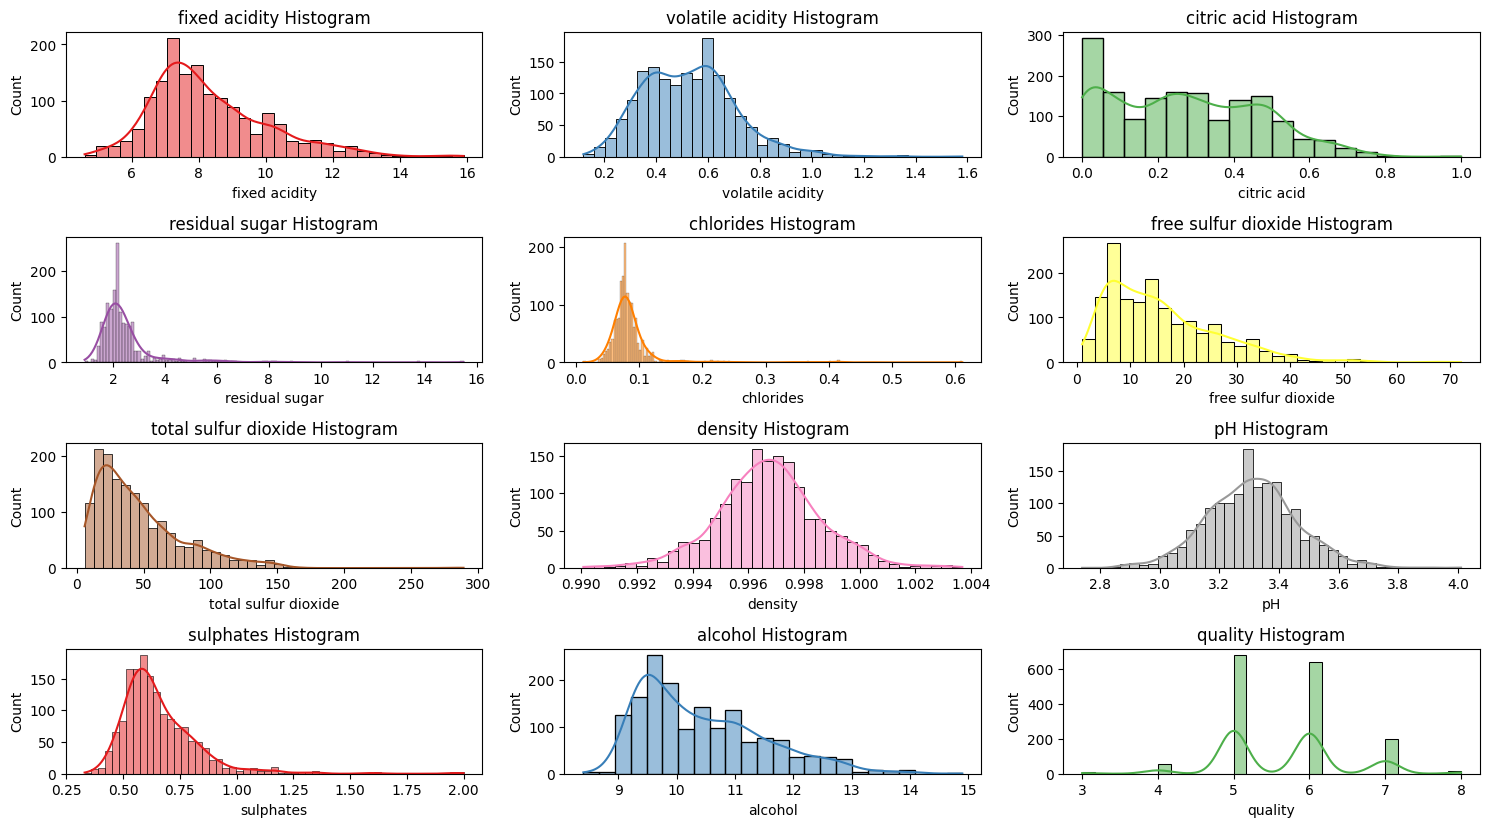

In [5]:
# Histogram
col_box = df.columns
color_palette = sns.color_palette("Set1", len(col_box))
plt.figure(figsize=(15, 10))

for i, column in enumerate(col_box, 1):
    plt.subplot((len(col_box) // 3) + 1, 3, i)
    sns.histplot(data=df, x=column, color=color_palette[i - 1], kde=True)
    plt.xlabel(column)
    plt.title(f'{column} Histogram')

plt.tight_layout()
plt.savefig('Histogram.png')
plt.show()

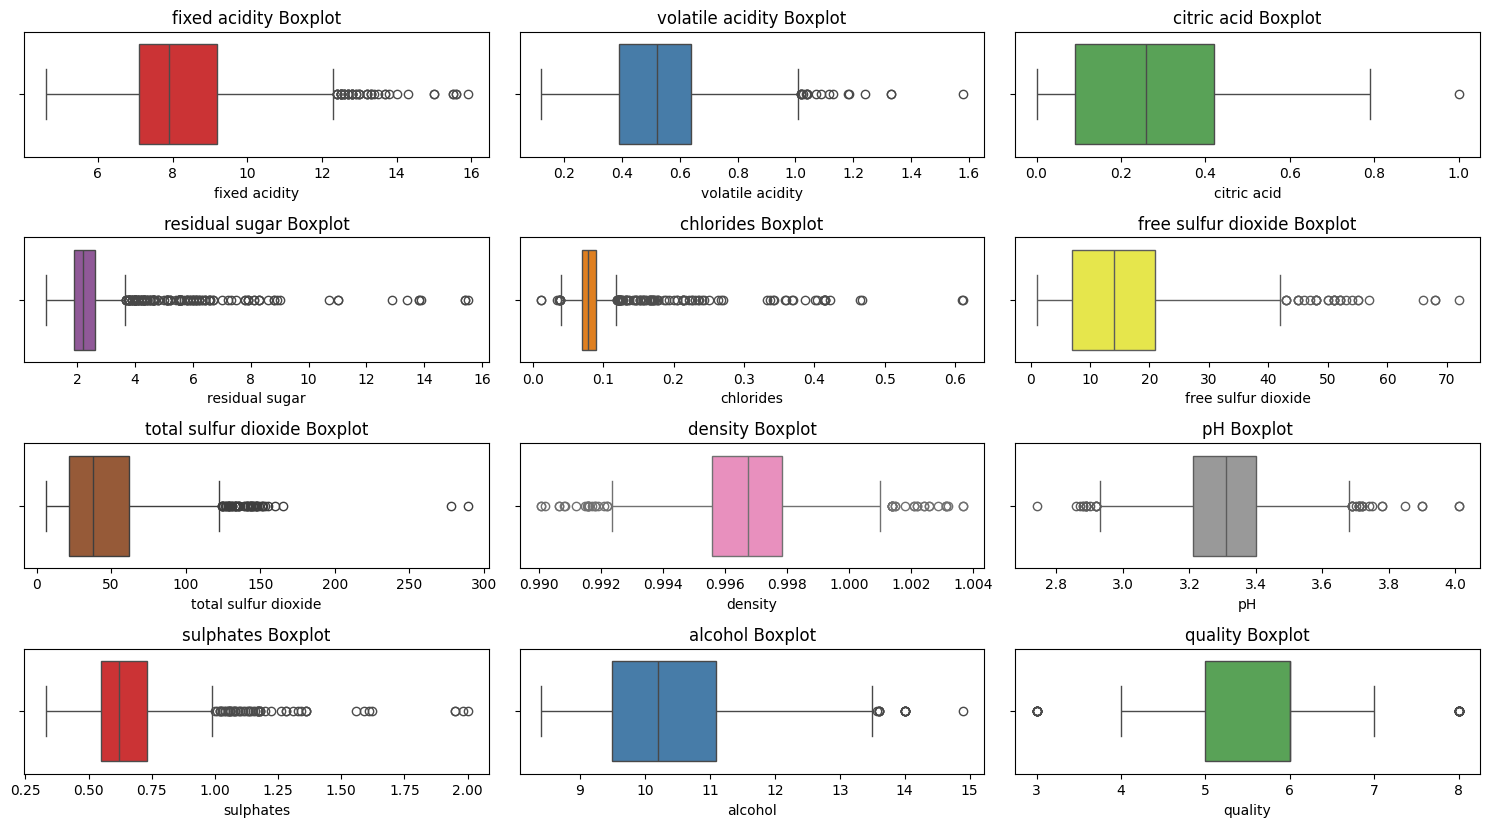

In [6]:
# Boxplot
col_box = df.columns
color_palette = sns.color_palette("Set1", len(col_box))
plt.figure(figsize = (15, 10))

for i, column in enumerate(col_box, 1):
    plt.subplot((len(col_box)//3)+1, 3, i)
    sns.boxplot(data=df, x=column, color=color_palette[i - 1])
    plt.xlabel(column)
    plt.title(f'{column} Boxplot')

plt.tight_layout()
plt.savefig('Boxplot(before).png')
plt.show()

In [7]:
df.skew()

fixed acidity           0.982751
volatile acidity        0.671593
citric acid             0.318337
residual sugar          4.540655
chlorides               5.680347
free sulfur dioxide     1.250567
total sulfur dioxide    1.515531
density                 0.071288
pH                      0.193683
sulphates               2.428672
alcohol                 0.860829
quality                 0.217802
dtype: float64

**Beberapa fitur terlihat skew kanan dan banyak outlier!!!**

In [8]:
# Hapus Outlier dengan Metode IQR
def drop_outliers(df, field_name):
    iqr = 1.5 * (np.percentile(df[field_name], 75) - np.percentile(df[field_name], 25))
    df.drop(df[df[field_name] > (iqr + np.percentile(df[field_name], 75))].index, inplace=True)
    df.drop(df[df[field_name] < (np.percentile(df[field_name], 25) - iqr)].index, inplace=True)

In [9]:
col_skew = ['chlorides', 'residual sugar', 'sulphates']
for col in col_skew:
  drop_outliers(df, col)

In [10]:
df.skew()

fixed acidity           0.910980
volatile acidity        0.577072
citric acid             0.328463
residual sugar          0.545291
chlorides               0.146955
free sulfur dioxide     1.013847
total sulfur dioxide    1.245060
density                -0.148117
pH                      0.288360
sulphates               0.538193
alcohol                 0.901826
quality                 0.341707
dtype: float64

In [11]:
df.reset_index(inplace = True, drop = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1311 non-null   float64
 1   volatile acidity      1311 non-null   float64
 2   citric acid           1311 non-null   float64
 3   residual sugar        1311 non-null   float64
 4   chlorides             1311 non-null   float64
 5   free sulfur dioxide   1311 non-null   float64
 6   total sulfur dioxide  1311 non-null   float64
 7   density               1311 non-null   float64
 8   pH                    1311 non-null   float64
 9   sulphates             1311 non-null   float64
 10  alcohol               1311 non-null   float64
 11  quality               1311 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 123.0 KB


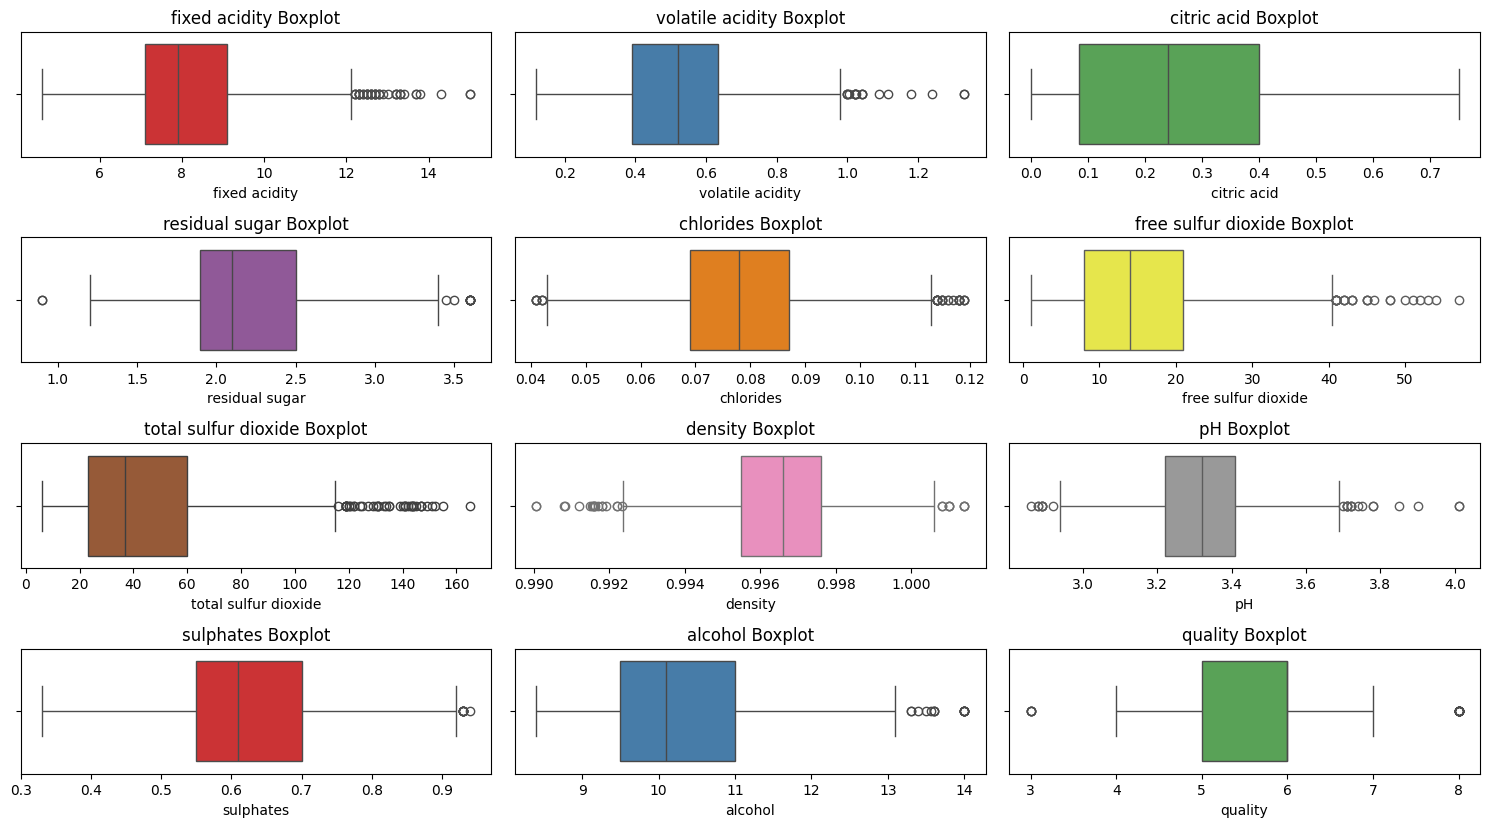

In [12]:
# kita cek lagi
col_box = df.columns
color_palette = sns.color_palette("Set1", len(col_box))
plt.figure(figsize = (15, 10))

for i, column in enumerate(col_box, 1):
    plt.subplot((len(col_box)//3)+1, 3, i)
    sns.boxplot(data=df, x=column, color=color_palette[i - 1])
    plt.xlabel(column)
    plt.title(f'{column} Boxplot')

plt.tight_layout()
plt.savefig('Boxplot(after).png')
plt.show()

**Berdasarkan `df.skew`, data sudah tidak terlalu skew dan tidak terlalu banyak outlier**
> Pertimbangkan juga jumlah datanya

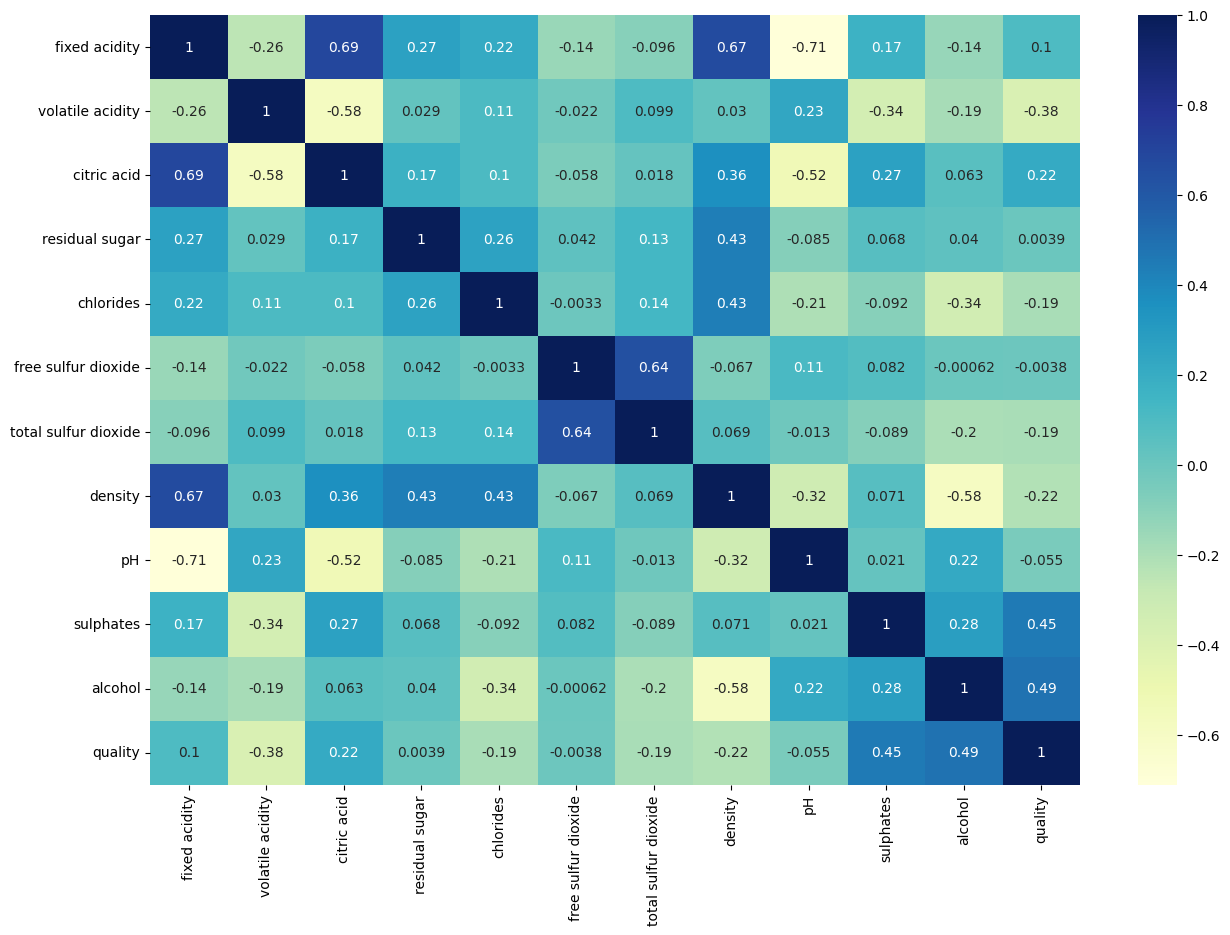

In [13]:
# Correlation Heatmap
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(), cmap="YlGnBu", annot=True)
plt.savefig('Heatmap_corr.png')

Berdasarkan korelasi tersebut, fitur `residual sugar` dan `free sulfur dioxide` akan di-*drop* karena memiliki korelasi yang kecil terhadap fitur target, yakni `quality`

In [14]:
df.drop(columns=['residual sugar', 'free sulfur dioxide'], inplace = True)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1311 entries, 0 to 1310
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1311 non-null   float64
 1   volatile acidity      1311 non-null   float64
 2   citric acid           1311 non-null   float64
 3   chlorides             1311 non-null   float64
 4   total sulfur dioxide  1311 non-null   float64
 5   density               1311 non-null   float64
 6   pH                    1311 non-null   float64
 7   sulphates             1311 non-null   float64
 8   alcohol               1311 non-null   float64
 9   quality               1311 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 102.5 KB


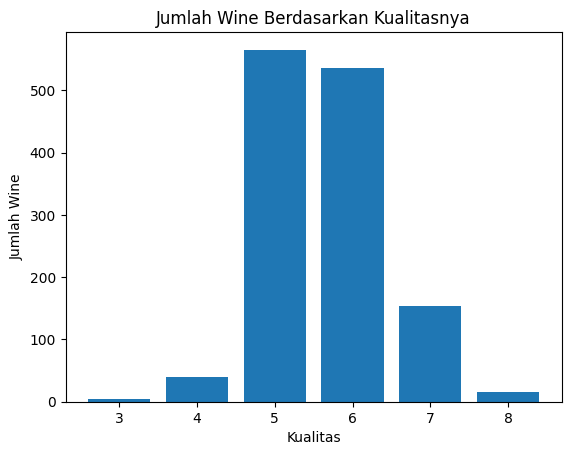

In [16]:
quality_counts = df['quality'].value_counts().sort_index()

plt.bar(quality_counts.index, quality_counts.values)
plt.title('Jumlah Wine Berdasarkan Kualitasnya')
plt.xlabel('Kualitas')
plt.ylabel('Jumlah Wine')

plt.savefig('Jumlah_wine.png')
plt.show()

Untuk dapat mempermudah klasifikasi, kita asumsikan:
- Kualitas Wine 3 hingga 5 => **Buruk** => 0
- Kualitas Wine 6 hingga 8 => **Bagus** => 1

In [17]:
def categorize_quality(quality):
    if quality >= 6:
        return 1
    else:
        return 0

df['quality'] = df['quality'].apply(categorize_quality)

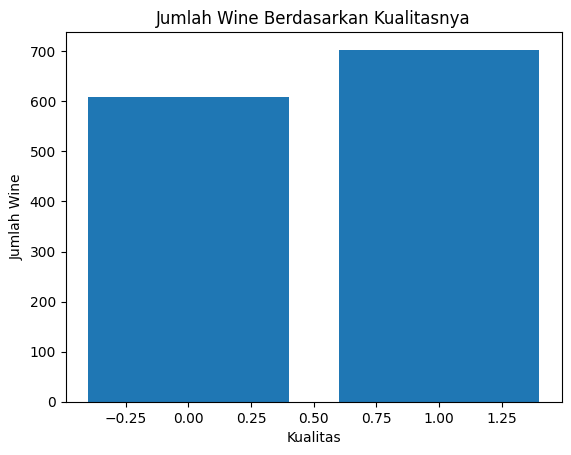

In [19]:
# Kita cek lagi
quality_counts = df['quality'].value_counts().sort_index()

plt.bar(quality_counts.index, quality_counts.values)
plt.title('Jumlah Wine Berdasarkan Kualitasnya')
plt.xlabel('Kualitas')
plt.ylabel('Jumlah Wine')

plt.savefig('Jumlah_wine(kategorikal).png')
plt.show()

# Pemisahan Data Train dan Valid

In [20]:
X = df.drop(columns = ['quality'])
scaler = StandardScaler()
X_norm = scaler.fit_transform(X)
X = pd.DataFrame(X_norm, columns = X.columns)

y = df['quality']

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state = 42, shuffle = True, test_size = 0.3)

# Prediksi dengan Model **AdaBoost**

In [22]:
AB = AdaBoostClassifier(random_state = 42)
AB.fit(X_train, y_train)
y_predict = AB.predict(X_valid)

print('Accuracy Score: ' + str(accuracy_score(y_valid, y_predict)))

Accuracy Score: 0.7360406091370558


In [23]:
# Hyperparameter Tuning
def randHyperParameterTuning(X_train, y_train):
    param_tuning = {
        'n_estimators': randint(50, 200),
        'learning_rate': [0.01, 0.05, 0.1, 0.3, 1]
    }

    AB = AdaBoostClassifier(random_state = 42)

    random_search = RandomizedSearchCV(estimator = AB,
                                 param_distributions = param_tuning,
                                 cv = 5,
                                 n_jobs = -1,
                                 verbose = 1)

    random_search.fit(X_train, y_train)
    return random_search.best_params_

rand_best_params = randHyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [24]:
rand_best_params

{'learning_rate': 0.1, 'n_estimators': 129}

In [25]:
AB = AdaBoostClassifier(**rand_best_params)
AB.fit(X_train, y_train)
y_predict = AB.predict(X_valid)

print('Accuracy Score: ' + str(accuracy_score(y_valid, y_predict)))

Accuracy Score: 0.7284263959390863


# Prediksi dengan Model **XGBoost**

In [26]:
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_valid)

print('Accuracy Score: ' + str(accuracy_score(y_valid, y_predict)))

Accuracy Score: 0.7588832487309645


In [27]:
def randHyperParameterTuning(X_train, y_train):
    param_tuning = {
        'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
        'max_depth': [3, 5, 6, 10],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.5, 0.7, 1],
        'colsample_bytree': [0.5, 0.7, 1],
        'n_estimators' : [100, 200, 500],
    }

    xgb = XGBClassifier(random_state = 42)

    random_search = RandomizedSearchCV(estimator = xgb,
                                 param_distributions = param_tuning,
                                 cv = 5,
                                 n_jobs = -1,
                                 verbose = 1)

    random_search.fit(X_train, y_train)
    return random_search.best_params_

rand_best_params = randHyperParameterTuning(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [28]:
rand_best_params

{'subsample': 1,
 'n_estimators': 100,
 'min_child_weight': 3,
 'max_depth': 5,
 'learning_rate': 0.3,
 'colsample_bytree': 1}

In [29]:
xgb = XGBClassifier(**rand_best_params)
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_valid)

print('Accuracy Score: ' + str(accuracy_score(y_valid, y_predict)))

Accuracy Score: 0.7766497461928934


# Prediksi dengan Model **ANN**

In [30]:
input_dim = len(X_train.columns)
ann = Sequential()

ann.add(Dense(128, activation = 'gelu', input_shape = (input_dim,)))
ann.add(Dropout(0.35))
ann.add(Dense(512, activation = 'gelu'))
ann.add(Dropout(0.35))
ann.add(Dense(512, activation = 'gelu'))
ann.add(Dropout(0.35))
ann.add(Dense(512, activation = 'gelu'))
ann.add(Dropout(0.35))
ann.add(Dense(1, activation = 'sigmoid'))

ann.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1280      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               66048     
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               2

In [31]:
checkpoint_path = 'training_model/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(checkpoint_path,
                              save_weights_only=True,
                              verbose=1)

lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=3,
                                            factor=0.5,
                                            min_lr = 1e-6,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 5,restore_best_weights=True,verbose=1)

In [32]:
ann.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [33]:
history = ann.fit (X_train, y_train,
                   validation_data = (X_valid, y_valid),
                   callbacks = [cp_callback, lr_reduction, early_stoping],
                   batch_size = 64,
                   epochs = 100)

Epoch 1/100
15/15 [==============================] - ETA: 0s - loss: 0.5835 - accuracy: 0.7143
Epoch 1: saving model to training_model/cp.ckpt
15/15 [==============================] - 7s 165ms/step - loss: 0.5835 - accuracy: 0.7143 - val_loss: 0.5312 - val_accuracy: 0.7081 - lr: 0.0010
Epoch 2/100
14/15 [===========================>..] - ETA: 0s - loss: 0.5063 - accuracy: 0.7589
Epoch 2: saving model to training_model/cp.ckpt
15/15 [==============================] - 1s 50ms/step - loss: 0.5026 - accuracy: 0.7612 - val_loss: 0.5401 - val_accuracy: 0.7310 - lr: 0.0010
Epoch 3/100
13/15 [=========================>....] - ETA: 0s - loss: 0.4943 - accuracy: 0.7596
Epoch 3: saving model to training_model/cp.ckpt
15/15 [==============================] - 1s 59ms/step - loss: 0.4968 - accuracy: 0.7568 - val_loss: 0.5341 - val_accuracy: 0.7259 - lr: 0.0010
Epoch 4/100
15/15 [==============================] - ETA: 0s - loss: 0.4957 - accuracy: 0.7612
Epoch 4: saving model to training_model/cp.ckp

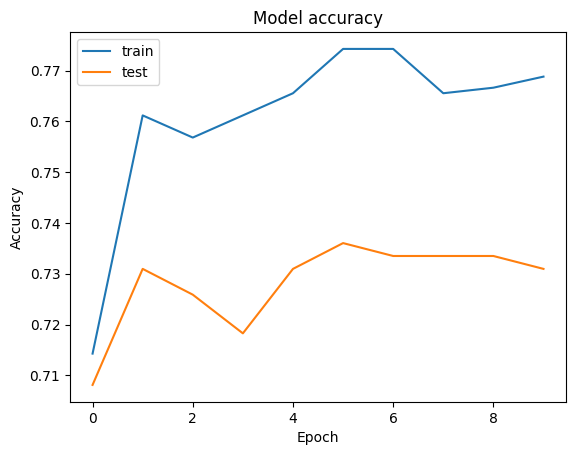

In [34]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Model_accuracy.png')
plt.show()

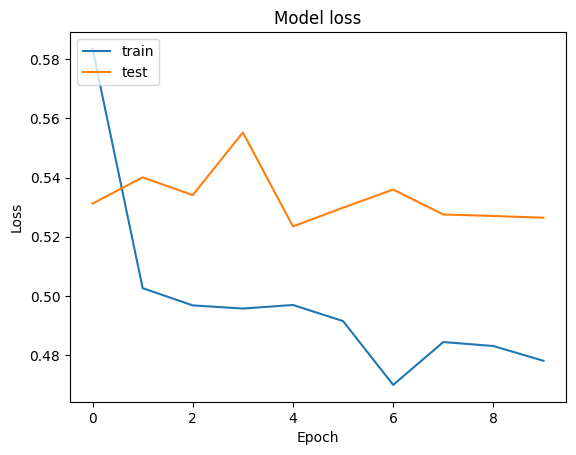

In [35]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('Model_loss.png')
plt.show()

In [36]:
ann.evaluate(X_valid, y_valid)

13/13 [==============================] - 0s 10ms/step - loss: 0.5235 - accuracy: 0.7310


[0.523460865020752, 0.7309644818305969]

**Arsitektur ANN ini adalah yang terbaik setelah beberapa percobaan mengganti ukuran layer dan fungsi aktivasinya**

# Kesimpulan
- Akurasi model AdaBoost = $\pm$ 73%
- Akurasi model XGBoost = $\pm$ 78%
- Akurasi model ANN = $\pm$ 73%

Oleh karena itu, pada kasus ini solusi terbaiknya adalah menggunakan model **XGBoost**

In [37]:
xgb = XGBClassifier(**rand_best_params)
xgb.fit(X_train, y_train)
y_predict = xgb.predict(X_valid)

print('Accuracy Score: ' + str(accuracy_score(y_valid, y_predict)))
xgb_scores = cross_val_score(xgb, X_train, y_train, cv=5)
print("Cross-validated Accuracy: %0.2f (+/- %0.2f)" % (xgb_scores.mean(), xgb_scores.std() * 2))

Accuracy Score: 0.7766497461928934
Cross-validated Accuracy: 0.80 (+/- 0.01)


              precision    recall  f1-score   support

           0       0.76      0.76      0.76       184
           1       0.79      0.79      0.79       210

    accuracy                           0.78       394
   macro avg       0.78      0.78      0.78       394
weighted avg       0.78      0.78      0.78       394



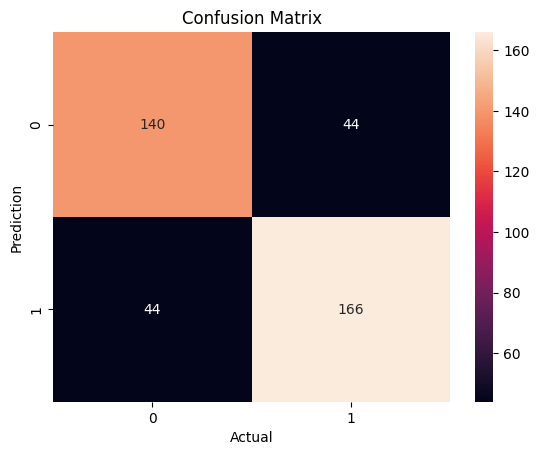

In [38]:
print(classification_report(y_valid, y_predict))
cf_matrix = confusion_matrix(y_valid, y_predict)
sns.heatmap(cf_matrix, annot=True, fmt='')
plt.xlabel("Actual")
plt.ylabel('Prediction')
plt.title('Confusion Matrix')
plt.savefig('Confusion_matrix.png')

# Sekian Terima Kasih

### Created by: Andika Rahman Teja